In [1]:
import pandas as pd
import re
import numpy as np
import zipfile

In [2]:
!wget https://www.manythings.org/anki/deu-eng.zip

--2021-07-10 13:37:56--  https://www.manythings.org/anki/deu-eng.zip
Resolving www.manythings.org (www.manythings.org)... 172.67.173.198, 104.21.55.222, 2606:4700:3031::6815:37de, ...
Connecting to www.manythings.org (www.manythings.org)|172.67.173.198|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9002192 (8.6M) [application/zip]
Saving to: ‘deu-eng.zip’

deu-eng.zip         100%[===================>]   8.58M  19.2MB/s    in 0.4s    

2021-07-10 13:37:57 (19.2 MB/s) - ‘deu-eng.zip’ saved [9002192/9002192]



In [3]:
with zipfile.ZipFile('deu-eng.zip', 'r') as zip:
    zip.extractall()
    
with open('deu.txt', mode='r', encoding='utf-8') as data:
    text = data.read()

In [4]:
lines = text.strip().split('\n')
lines = [l.split('\t') for l in lines]

In [5]:
eng = [l[0] for l in lines]
ger = [l[1] for l in lines]

In [6]:
d = {'English':eng, 'German':ger}
df = pd.DataFrame(d)
df

,English,German
0,Go.,Geh.
1,Hi.,Hallo!
2,Hi.,Grüß Gott!
3,Run!,Lauf!
4,Run.,Lauf!
...,...,...
240352,If someone who doesn't know your background sa...,"Wenn jemand Fremdes dir sagt, dass du dich wie..."
240353,If someone who doesn't know your background sa...,"Wenn jemand, der nicht weiß, woher man kommt, ..."
240354,It may be impossible to get a completely error...,"Es ist wohl unmöglich, einen vollkommen fehler..."
240355,I know that adding sentences only in your nati...,"Ich weiß wohl, dass das ausschließliche Beitra..."


In [7]:
df.shape

(240357, 2)

# Preprocessing

In [8]:
special_char_map = {ord('ä'):'ae', ord('ü'):'ue', ord('ö'):'oe', ord('ß'):'ss'}

In [9]:
def clean(text):
    text = text.translate(special_char_map)
    text = re.sub("'", '', text)
    words = re.findall(r'\w+', text)
    words = [word.lower() for word in words]
    return " ".join(words)

In [10]:
df['Eng_clean'] = df['English'].apply(clean)
df['Ger_clean'] = df['German'].apply(clean)

In [11]:
df['Eng_len'] = df['Eng_clean'].apply(lambda x: len(x.split()))
df['Ger_len'] = df['Ger_clean'].apply(lambda x: len(x.split()))

In [12]:
df['Eng_len'].mean()

6.311715489875477

In [13]:
df['Ger_len'].mean()

6.342157707077389

In [14]:
max_words = 7

In [15]:
df_filter = df[(df['Eng_len'] <= max_words) & (df['Ger_len'] <= max_words)]

In [16]:
df_filter

,English,German,Eng_clean,Ger_clean,Eng_len,Ger_len
0,Go.,Geh.,go,geh,1,1
1,Hi.,Hallo!,hi,hallo,1,1
2,Hi.,Grüß Gott!,hi,gruess gott,1,2
3,Run!,Lauf!,run,lauf,1,1
4,Run.,Lauf!,run,lauf,1,1
...,...,...,...,...,...,...
229446,"Salamanders are amphibians, whereas geckos are...","Salamander sind Amphibien, während Geckos Rept...",salamanders are amphibians whereas geckos are ...,salamander sind amphibien waehrend geckos rept...,7,7
229520,The government's decision had far-reaching imp...,Der Regierungsbeschluss hatte weitreichende Fo...,the governments decision had far reaching impl...,der regierungsbeschluss hatte weitreichende fo...,7,5
232416,Everyone should periodically receive a physica...,Jeder sollte sich regelmäßig ärztlich untersuc...,everyone should periodically receive a physica...,jeder sollte sich regelmaessig aerztlich unter...,7,7
232636,Most developing countries are suffering from o...,Die meisten Entwicklungsländer leiden an Überb...,most developing countries are suffering from o...,die meisten entwicklungslaender leiden an über...,7,6


In [17]:
df_50000 = df_filter.sample(n=50000,random_state=101)

In [18]:
df_50000

,English,German,Eng_clean,Ger_clean,Eng_len,Ger_len
111752,We just weren't good enough.,Wir waren einfach nicht gut genug.,we just werent good enough,wir waren einfach nicht gut genug,5,6
28717,Do you want a ride?,Soll ich euch mitnehmen?,do you want a ride,soll ich euch mitnehmen,5,4
83835,Tom refused to help Mary.,"Tom weigerte sich, Maria zu helfen.",tom refused to help mary,tom weigerte sich maria zu helfen,5,6
78003,He has written two books.,Er hat zwei Bücher geschrieben.,he has written two books,er hat zwei buecher geschrieben,5,5
58830,You're the one I love.,"Du bist es, den ich liebe.",youre the one i love,du bist es den ich liebe,5,6
...,...,...,...,...,...,...
112992,You're really a nice person.,Du bist wirklich ein netter Mensch!,youre really a nice person,du bist wirklich ein netter mensch,5,6
65952,Tom walked very slowly.,Tom ging sehr langsam.,tom walked very slowly,tom ging sehr langsam,4,4
153207,Were you with Tom the whole time?,Wart ihr die ganze Zeit bei Tom?,were you with tom the whole time,wart ihr die ganze zeit bei tom,7,7
120837,What did that suggest to you?,Was hat euch das gesagt?,what did that suggest to you,was hat euch das gesagt,6,5


# Text to Sequence Conversion

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_50000['Ger_clean'], df_50000['Eng_clean'],
                                                    test_size=0.2, random_state=101, stratify=df_50000['Ger_len'])

In [20]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [21]:
ger_tokenizer = Tokenizer()
ger_tokenizer.fit_on_texts(df_50000['Ger_clean'])
ger_vocab_size = len(ger_tokenizer.word_index) + 1

ger_tr = ger_tokenizer.texts_to_sequences(X_train)
X_train_s = pad_sequences(ger_tr, maxlen=max_words, padding='post')

ger_ts = ger_tokenizer.texts_to_sequences(X_test)
X_test_s = pad_sequences(ger_ts, maxlen=max_words, padding='post')

In [22]:
eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(df_50000['Eng_clean'])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_tr = eng_tokenizer.texts_to_sequences(y_train)
y_train_s = pad_sequences(eng_tr, maxlen=max_words, padding='post')

eng_ts = eng_tokenizer.texts_to_sequences(y_test)
y_test_s = pad_sequences(eng_ts, maxlen=max_words, padding='post')

In [23]:
eng_vocab_size, ger_vocab_size

(8776, 14753)

# Model Building

In [24]:
from keras.callbacks import ModelCheckpoint
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Activation, RepeatVector, Dropout
from keras.models import Sequential, load_model

import matplotlib.pyplot as plt

from nltk.translate.bleu_score import corpus_bleu

In [25]:
def model_info(model):
    for l in model.layers:
        for k,v in l.get_config().items():
            if k not in ['trainable', 'dtype'] and v and type(v) is not dict:
                print(k,v)
        print()

In [55]:
model = Sequential()
model.add(Embedding(input_dim=ger_vocab_size, output_dim=256, input_length=max_words, mask_zero=True))
model.add(LSTM(256))
model.add(RepeatVector(max_words))
model.add(LSTM(256, return_sequences=True))
model.add(Dense(eng_vocab_size, activation='softmax'))
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 7, 256)            3776768   
_________________________________________________________________
lstm_14 (LSTM)               (None, 256)               525312    
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 7, 256)            0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 7, 256)            525312    
_________________________________________________________________
dense_7 (Dense)              (None, 7, 8776)           2255432   
Total params: 7,082,824
Trainable params: 7,082,824
Non-trainable params: 0
_________________________________________________________________
None


In [56]:
filename = 'model_g2e.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

model.fit(X_train_s, y_train_s, epochs=30, batch_size=512, validation_data=(X_test_s, y_test_s), callbacks=[checkpoint], verbose=2)

Epoch 1/30
79/79 - 16s - loss: 5.2748 - val_loss: 4.8733

Epoch 00001: val_loss improved from inf to 4.87332, saving model to model_g2e.h5
Epoch 2/30
79/79 - 8s - loss: 4.7358 - val_loss: 4.7934

Epoch 00002: val_loss improved from 4.87332 to 4.79338, saving model to model_g2e.h5
Epoch 3/30
79/79 - 8s - loss: 4.5389 - val_loss: 4.5408

Epoch 00003: val_loss improved from 4.79338 to 4.54082, saving model to model_g2e.h5
Epoch 4/30
79/79 - 8s - loss: 4.3868 - val_loss: 4.3621

Epoch 00004: val_loss improved from 4.54082 to 4.36215, saving model to model_g2e.h5
Epoch 5/30
79/79 - 8s - loss: 4.2394 - val_loss: 4.2567

Epoch 00005: val_loss improved from 4.36215 to 4.25669, saving model to model_g2e.h5
Epoch 6/30
79/79 - 8s - loss: 4.1456 - val_loss: 4.2018

Epoch 00006: val_loss improved from 4.25669 to 4.20177, saving model to model_g2e.h5
Epoch 7/30
79/79 - 8s - loss: 4.0274 - val_loss: 4.1103

Epoch 00007: val_loss improved from 4.20177 to 4.11033, saving model to model_g2e.h5
Epoch 8/3

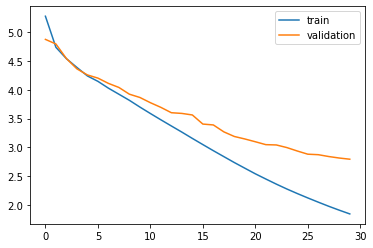

name embedding_7
batch_input_shape (None, 7)
input_dim 14753
output_dim 256
mask_zero True
input_length 7

name lstm_14
units 256
activation tanh
recurrent_activation hard_sigmoid
use_bias True
unit_forget_bias True
implementation 1

name repeat_vector_3
n 7

name lstm_15
return_sequences True
units 256
activation tanh
recurrent_activation hard_sigmoid
use_bias True
unit_forget_bias True
implementation 1

name dense_7
units 8776
activation softmax
use_bias True



In [57]:
#Epoch - 30 1st Model
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.legend(['train', 'validation'])
plt.show()

model_info(model)

# Model Evaluation

In [49]:
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

In [50]:
def evaluate(source, target, tokenizer):
    predicted = []
    for i in range(source.shape[0]):
        seq = source[i].reshape((1,max_words))
        pred = model.predict(seq)[0]
        pr_seq = [np.argmax(p) for p in pred]
        p_text = [word_for_id(n, tokenizer) for n in pr_seq if word_for_id(n, tokenizer) is not None]
        predicted.append(p_text)
    return predicted

In [58]:
model = load_model('model_g2e.h5')

In [59]:
predicted_train = evaluate(X_train_s, y_train_s, eng_tokenizer)
actual_train = [[y_train.iloc[i].split()] for i in range(y_train.shape[0])]

print('Train')
print('BLEU-1: %f' % corpus_bleu(actual_train, predicted_train, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual_train, predicted_train, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(actual_train, predicted_train, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(actual_train, predicted_train, weights=(0.25, 0.25, 0.25, 0.25)))

predicted_test = evaluate(X_test_s, y_test_s, eng_tokenizer)
actual_test = [[y_test.iloc[i].split()] for i in range(y_test.shape[0])]

print('Test')
print('BLEU-1: %f' % corpus_bleu(actual_test, predicted_test, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual_test, predicted_test, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(actual_test, predicted_test, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(actual_test, predicted_test, weights=(0.25, 0.25, 0.25, 0.25)))


Train
BLEU-1: 0.519241
BLEU-2: 0.369473
BLEU-3: 0.299025
BLEU-4: 0.182923
Test
BLEU-1: 0.430342
BLEU-2: 0.284057
BLEU-3: 0.223003
BLEU-4: 0.124176


In [60]:
d_train = {'German':X_train, 'Actual':y_train, 'Predicted':[' '.join(p) for p in predicted_train]}
df_train = pd.DataFrame(d_train)
df_train

,German,Actual,Predicted
34907,du hast ein versprechen abgelegt,you made a promise,you have a choice
69334,gestern waere ich fast ums leben gekommen,i almost died yesterday,i almost laughed died
170294,in rom gibt es viele alte gebaeude,rome has a lot of ancient buildings,there is a lot of of water
70624,ich wollte dich beeindrucken,i wanted to impress you,i wanted to to
135184,die anderen maedchen lachten ueber sie,the other girls laughed at her,the girls girls girls to her
...,...,...,...
130261,du fuehlst dich wohl hier nicht wahr,youre happy here arent you,youre arent youre here you
168657,mir ist nichts verdaechtiges aufgefallen,i didnt notice anything suspicious,i didnt have anything anything
177805,tom sagte dass mary keinen spass hatte,tom said that mary wasnt having fun,tom said mary he was
17107,ich scherze nicht,i am not kidding,i dont not


In [61]:
d_test = {'German':X_test, 'Actual':y_test, 'Predicted':[' '.join(p) for p in predicted_test]}
df_test = pd.DataFrame(d_test)
df_test

,German,Actual,Predicted
78923,ich spreche kein franzoesisch,i dont speak any french,i dont speak french french
94855,du kochst wirklich gut,youre really a good cook,you are really good
83360,tom ist gerade im garten,tom is in the garden now,tom is in in the garden
133260,ich war gestern bei tom,i was at toms place yesterday,i was tom tom yesterday
165989,tom merkte dass maria ungluecklich war,tom realized that mary was unhappy,tom said mary mary was
...,...,...,...
3541,komm und sieh,come and see,come and and
57997,was hast du sonst noch gekauft,what else did you buy,what did you you have
60956,ich kenne dieses lied nicht,i dont know that song,i dont that this this
498,es ist tom,its tom,its is
